In [1]:
%cd ../..

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-


In [2]:
import os
import shutil

import joblib
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

from pathlib import Path

from src.forecasting.ml_forecasting import (
    MissingValueConfig,
    calculate_metrics,
)
from src.utils import plotting_utils
from tqdm.autonotebook import tqdm
from src.forecasting.ml_forecasting import calculate_metrics
from src.utils import ts_utils

%load_ext autoreload
%autoreload 2
np.random.seed(42)
tqdm.pandas()

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-\src\utils\data_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [196]:
os.makedirs("imgs/chapter_14", exist_ok=True)
preprocessed = Path("data/london_smart_meters/preprocessed")
output = Path("data/london_smart_meters/output")
TRAIN_SUBSAMPLE = True

## Utility Functions

In [4]:
def format_plot(fig, legends=None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title_text=title,
        title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
        titlefont={"size": 20},
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=0.98,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title_text=ylabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
        xaxis=dict(
            title_text=xlabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        )
    )
    return fig

In [5]:
from itertools import cycle


def plot_forecast(pred_df, forecast_columns, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns) == len(forecast_display_names)
    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = [
        "rgba(" + ",".join([str(c) for c in plotting_utils.hex_to_rgb(c)]) + ",<alpha>)"
        for c in px.colors.qualitative.Plotly
    ]
    act_color = colors[0]
    colors = cycle(colors[1:])
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=pred_df[mask].index,
            y=pred_df[mask].energy_consumption,
            mode="lines",
            line=dict(color=act_color.replace("<alpha>", "0.9")),
            name="Actual Consumption",
        )
    )
    for col, display_col in zip(forecast_columns, forecast_display_names):
        fig.add_trace(
            go.Scatter(
                x=pred_df[mask].index,
                y=pred_df.loc[mask, col],
                mode="lines",
                line=dict(dash="dot", color=next(colors).replace("<alpha>", "1")),
                name=display_col,
            )
        )
    return fig

def highlight_abs_min(s, props=''):
    return np.where(s == np.nanmin(np.abs(s.values)), props, '')

def evaluate_forecast(pred_df, train_data, fc_column, name, target_name="energy_consumption"):
    metric_l = []
    for _id in tqdm(pred_df.index.get_level_values(0).unique(), desc="Calculating metrics..."):
        target = pred_df.xs(_id)[[target_name]]
        _y_pred = pred_df.xs(_id)[[fc_column]]
        history = train_data.xs(_id)[[target_name]]
        # display(history.tail())
        # display(_y_pred.head())
        # display(target.head())
        metric_l.append(
            calculate_metrics(target, _y_pred, name=name, y_train=history)
        )
    eval_metrics_df = pd.DataFrame(metric_l)
    agg_metrics = {
            "Algorithm": name,
            "MAE": np.nanmean(np.abs(pred_df[fc_column]-pred_df[target_name])),
            "MSE": np.nanmean(np.power(pred_df[fc_column]-pred_df[target_name], 2)),
            "meanMASE": eval_metrics_df.loc[:, "MASE"].mean(),
            "Forecast Bias": 100*(np.nansum(pred_df[fc_column])-np.nansum(pred_df[target_name]))/np.nansum(pred_df[target_name])
    }
    return agg_metrics, eval_metrics_df

In [6]:
from collections import namedtuple

FeatureConfig = namedtuple(
    "FeatureConfig",
    [
        "target",
        "index_cols",
        "static_categoricals",
        "static_reals",
        "time_varying_known_categoricals",
        "time_varying_known_reals",
        "time_varying_unknown_reals",
        "group_ids"
    ],
)

## Reading the data

In [95]:
#Reading the missing value imputed and train test split data
train_df = pd.read_parquet(preprocessed/"selected_blocks_train_missing_imputed_feature_engg.parquet")
# Read in the Validation dataset as test_df so that we predict on it
test_df = pd.read_parquet(preprocessed/"selected_blocks_val_missing_imputed_feature_engg.parquet")
# test_df = pd.read_parquet(preprocessed/"selected_blocks_test_missing_imputed_feature_engg.parquet")

In [96]:
# To run on smaller set of data for daster iteration.
if TRAIN_SUBSAMPLE:
    SAMPLE = 10
    sampled_LCLids = pd.Series(train_df.LCLid.unique().remove_unused_categories().categories).sample(SAMPLE, random_state=99).tolist()
    train_df = train_df.loc[train_df.LCLid.isin(sampled_LCLids)]
    test_df = test_df.loc[test_df.LCLid.isin(sampled_LCLids)]

## Defining the different features

In [97]:
feat_config = FeatureConfig(
    target="energy_consumption",
    index_cols=["LCLid", "timestamp"],
    static_categoricals=[
        "LCLid",
        "stdorToU",
        "Acorn",
        "Acorn_grouped",
        "file",
    ],  # Categoricals which does not change with time
    static_reals=[],  # Reals which does not change with time
    time_varying_known_categoricals=[  # Categoricals which change with time
        "holidays",
        "timestamp_Dayofweek",
    ],
    time_varying_known_reals=[  # Reals which change with time
        "apparentTemperature",
    ],  
    time_varying_unknown_reals=[  # Reals which change with time, but we don't have the future. Like the target
        "energy_consumption"
    ],  
    group_ids=[  # Feature or list of features which uniquely identifies each entity
        "LCLid"
    ],  
)

### Creating a continuous time index for PyTorch Forecasting

In [98]:
# Combining train and test with a flag
train_df['train'] = True
test_df['train'] = False
data = pd.concat([train_df, test_df])
del train_df, test_df
# Adding the time index
data['time_idx'] = data.timestamp.apply(lambda x: x.value)
diff = data.iloc[1]['time_idx'] - data.iloc[0]['time_idx']
data["_min_time_idx"] = data.groupby("LCLid", observed=True)['time_idx'].transform("min")
data['time_idx'] = ((data['time_idx']-data['_min_time_idx'])/diff).astype(int)
data.drop(columns="_min_time_idx", inplace=True)
# separating to train and test
train_df = data.loc[data.train]
test_df = data.loc[~data.train]
del data

### Converting the categoricals to Category dtype

In [99]:
train_df[
    feat_config.static_categoricals + feat_config.time_varying_known_categoricals
] = train_df[
    feat_config.static_categoricals + feat_config.time_varying_known_categoricals
].astype(
    "object"
)

test_df[
    feat_config.static_categoricals + feat_config.time_varying_known_categoricals
] = test_df[
    feat_config.static_categoricals + feat_config.time_varying_known_categoricals
].astype(
    "object"
)

### Handling Missing Values

In [ ]:
#Checking missing values
n = train_df.isna().any()
n[n]

pressure                                          True
energy_consumption_lag_1                          True
energy_consumption_lag_2                          True
energy_consumption_lag_3                          True
energy_consumption_lag_4                          True
energy_consumption_lag_5                          True
energy_consumption_lag_46                         True
energy_consumption_lag_47                         True
energy_consumption_lag_48                         True
energy_consumption_lag_49                         True
energy_consumption_lag_50                         True
energy_consumption_lag_334                        True
energy_consumption_lag_335                        True
energy_consumption_lag_336                        True
energy_consumption_lag_337                        True
energy_consumption_lag_338                        True
energy_consumption_rolling_3_mean                 True
energy_consumption_rolling_3_std                  True
energy_con

In [ ]:
# We aren't using any of these features. So let it be

# Training Global Models

In [14]:
import pytorch_lightning as pl
pl.seed_everything(42)
import torch

from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE, MAE

Global seed set to 42


In [194]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard
# os.makedirs("lightning_logs", exist_ok=True)
# %tensorboard --logdir lightning_logs/

# Or start the tensorboard in a separate command prompt/terminal using
# tensorboard --logdir lightning_logs/

### Config

In [197]:
max_prediction_length = 1
max_encoder_length = 48*2
batch_size = 512  # set this to a value which your GPU can handle
train_model = False # Set this to True to train model. Else will load saved models

In [16]:
metric_record = []
individual_metrics = dict()

### Creating dataframes for train, val and test

In [103]:
train_df.timestamp.max(), test_df.timestamp.min()

(Timestamp('2013-12-31 23:30:00'), Timestamp('2014-01-01 00:00:00'))

In [104]:
#Adding 2 days of history (48*2) to create the samples
history_cutoff = train_df.timestamp.max() - pd.Timedelta(2, "D")
hist_df = train_df[train_df.timestamp>history_cutoff]
print(f"History Min: {hist_df.timestamp.min()} | Max: {hist_df.timestamp.max()} | Length: {len(hist_df.timestamp.unique())}")

History Min: 2013-12-30 00:00:00 | Max: 2013-12-31 23:30:00 | Length: 96


In [105]:
#Keeping 1 days aside as a validation set
cutoff = train_df.timestamp.max() - pd.Timedelta(1, "D")
#Adding 2 days of history (48*2) to create the samples
history_cutoff = train_df.timestamp.max() - pd.Timedelta(3, "D")
val_history = train_df[(train_df.timestamp>=history_cutoff)&(train_df.timestamp<=cutoff)].reset_index(drop=True)
val_df = train_df[train_df.timestamp>cutoff].reset_index(drop=True)
train_df = train_df[train_df.timestamp<=cutoff].reset_index(drop=True)
print("Split Timestamps:")
print(f"Train Max: {train_df.timestamp.max()} | Val History Min and Max: {val_history.timestamp.min(), val_history.timestamp.max()} | Val Min and Max: {val_df.timestamp.min(), val_df.timestamp.max()}")
print(f"Val History Size: {len(val_history.timestamp.unique())} | Val Size: {len(val_df.timestamp.unique())}")

Split Timestamps:
Train Max: 2013-12-30 23:30:00 | Val History Min and Max: (Timestamp('2013-12-28 23:30:00'), Timestamp('2013-12-30 23:30:00')) | Val Min and Max: (Timestamp('2013-12-31 00:00:00'), Timestamp('2013-12-31 23:30:00'))
Val History Size: 97 | Val Size: 48


In [106]:
pred_df = test_df[feat_config.index_cols+[feat_config.target]+['time_idx']].copy()
# pred_df.set_index(feat_config.index_cols, inplace=True)

In [107]:
cols = feat_config.index_cols + [feat_config.target]
full_df = pd.concat(
    [
        train_df[cols],
        val_df[cols],
    ]
).set_index(feat_config.index_cols)

## Baseline

Using just the history of the time series

In [184]:
tag = "simple"

### Converting data into TimeSeriesDataset from PyTorch Forecasting

In [185]:
# Defining the training dataset
training = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target=feat_config.target,
    group_ids=feat_config.group_ids,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=[
        "energy_consumption",
    ],
    target_normalizer=GroupNormalizer(
        groups=feat_config.group_ids, transformation=None
    )
)
# Defining the validation dataset with the same parameters as training
validation = TimeSeriesDataSet.from_dataset(training, pd.concat([val_history,val_df]).reset_index(drop=True), stop_randomization=True)
# Defining the test dataset with the same parameters as training
test = TimeSeriesDataSet.from_dataset(training, pd.concat([hist_df, test_df]).reset_index(drop=True), stop_randomization=True)

In [186]:
# Making the dataloaders
# num_workers can be increased in linux to speed-up training
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [187]:
# Testing the dataloader
x, y = next(iter(train_dataloader))
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")
print("\nsize of y =")
print(f"\ty = {y[0].size()}")


sizes of x =
	encoder_cat = torch.Size([512, 96, 0])
	encoder_cont = torch.Size([512, 96, 1])
	encoder_target = torch.Size([512, 96])
	encoder_lengths = torch.Size([512])
	decoder_cat = torch.Size([512, 1, 0])
	decoder_cont = torch.Size([512, 1, 1])
	decoder_target = torch.Size([512, 1])
	decoder_lengths = torch.Size([512])
	decoder_time_idx = torch.Size([512, 1])
	groups = torch.Size([512, 1])
	target_scale = torch.Size([512, 2])

size of y =
	y = torch.Size([512, 1])


### Creating the Model

In [188]:
# Importing the skeleton and helper models from src
from src.dl.ptf_models import SingleStepRNN, SingleStepRNNModel

**The helper model which is a custom PyTorch Forecasting model is as below:**

It is designed for simple RNN based forecasting, which is what we will be using to show different strategies of global modelling
```python
class SingleStepRNNModel(BaseModel):
    def __init__(self, network_callable: Callable, model_params: Dict, **kwargs):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters(model_params)
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)
        self.network = network_callable(**model_params)

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        prediction = self.network(x)
        # rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])
        # We need to return a dictionary that at least contains the prediction
        # The parameter can be directly forwarded from the input.
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)
```

### Defining the Forward function

In [189]:
from typing import Dict

class SimpleRNNModel(SingleStepRNN):
    def __init__(
        self,
        rnn_type: str,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        bidirectional: bool,
    ):
        super().__init__(rnn_type, input_size, hidden_size, num_layers, bidirectional)

    def forward(self, x: Dict):
        # Using the encoder continuous which has the history window
        x = x["encoder_cont"] # x --> (batch_size, seq_len, input_size)
        # Processing through the RNN
        x, _ = self.rnn(x)  # --> (batch_size, seq_len, hidden_size)
        # Using a FC layer on last hidden state
        x = self.fc(x[:,-1,:])  # --> (batch_size, seq_len, 1)
        return x

In [190]:
model_params = dict(
    rnn_type="LSTM",
    input_size=len(training.reals),
    hidden_size=256, #128
    num_layers=2,
    bidirectional=False,
)
other_params = dict(
    learning_rate=5e-5,
    optimizer="adam",
    loss=RMSE(),
    logging_metrics=[RMSE(), MAE()],
)

In [191]:
model = SingleStepRNNModel.from_dataset(
    training,
    network_callable=SimpleRNNModel,
    model_params=model_params,
    **other_params
)
#Testing out the model
x, y = next(iter(train_dataloader))
_ = model(x)
type(_), _.prediction.shape

(pytorch_forecasting.utils.TupleOutputMixIn.to_network_output.<locals>.Output,
 torch.Size([512, 1]))

In [192]:
# model = SingleStepRNNModel.load_from_checkpoint(r"C:\\Users\\ManuJoseph\\OneDrive - Thoucentric\\Work\\Projects\\Playground\\AdvancedTimeSeriesForecastingBook\\Github\\Modern-Time-Series-Forecasting-with-Python-\\lightning_logs\\version_21\\checkpoints\\epoch=9-step=5789.ckpt")

### Training the model

In [161]:
saved_model_sampled = 'notebooks/Chapter14/saved_models/baseline_sampled.ckpt'
saved_model_full = 'notebooks/Chapter14/saved_models/baseline.ckpt'

'notebooks/Chapter14/saved_models/baseline_sampled.ckpt'

In [195]:
if train_model:
    trainer = pl.Trainer(
        auto_select_gpus=True,
        gpus=-1,
        min_epochs=1,
        max_epochs=20,
        callbacks=[
            pl.callbacks.EarlyStopping(monitor="val_loss", patience=2),
            pl.callbacks.ModelCheckpoint(
                monitor="val_loss", save_last=True, mode="min", auto_insert_metric_name=True
            ),
        ],
        # fast_dev_run=True
        # precision = 16
    )
    trainer.fit(
        model,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    #Loading the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
else:
    best_model_path = saved_model_sampled if TRAIN_SUBSAMPLE else saved_model_full
print(f"Loading the model from: {best_model_path}")
best_model = SingleStepRNNModel.load_from_checkpoint(best_model_path)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params
---------------------------------------------------
0 | loss            | RMSE           | 0     
1 | logging_metrics | ModuleList     | 0     
2 | network         | SimpleRNNModel | 791 K 
---------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [36]:
pred, index = best_model.predict(test, return_index=True, show_progress_bar=True)
index[tag] = pred
pred_df = pred_df.reset_index().merge(index, on=["time_idx","LCLid"], how='left').set_index(feat_config.index_cols)
agg_metrics, eval_metrics_df = evaluate_forecast(
    pred_df = pred_df,
    train_data = full_df,
    fc_column=tag,
    name=tag,
)
metric_record.append(agg_metrics)
individual_metrics[tag]=eval_metrics_df

Predict:   0%|          | 0/233 [00:00<?, ? batches/s]

In [38]:
pd.DataFrame(metric_record)

,Algorithm,MAE,MSE,meanMASE,Forecast Bias
0,simple,0.079929,0.025419,0.942638,-2.840411


## Baseline + Time-varying Information

Using the history of the time series, static, and time varying features

In [39]:
tag = "simple+time_varying"

### Converting data into TimeSeriesDataset from PyTorch Forecasting

In [40]:
# Defining the training dataset
training = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target=feat_config.target,
    group_ids=feat_config.group_ids,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    # static_categoricals=feat_config.static_categoricals,
    # static_reals=feat_config.static_reals,
    time_varying_known_categoricals=feat_config.time_varying_known_categoricals,
    time_varying_known_reals=feat_config.time_varying_known_reals,
    time_varying_unknown_reals=[
        "energy_consumption",
    ],
    target_normalizer=GroupNormalizer(
        groups=feat_config.group_ids, transformation=None
    )
)
# Defining the validation dataset with the same parameters as training
validation = TimeSeriesDataSet.from_dataset(training, pd.concat([val_history,val_df]).reset_index(drop=True), stop_randomization=True)
# Defining the test dataset with the same parameters as training
test = TimeSeriesDataSet.from_dataset(training, pd.concat([hist_df, test_df]).reset_index(drop=True), stop_randomization=True)

In [41]:
# Making the dataloaders
# num_workers can be increased in linux to speed-up training
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [42]:
# Testing the dataloader
x, y = next(iter(train_dataloader))
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")
print("\nsize of y =")
print(f"\ty = {y[0].size()}")


sizes of x =
	encoder_cat = torch.Size([512, 96, 2])
	encoder_cont = torch.Size([512, 96, 2])
	encoder_target = torch.Size([512, 96])
	encoder_lengths = torch.Size([512])
	decoder_cat = torch.Size([512, 1, 2])
	decoder_cont = torch.Size([512, 1, 2])
	decoder_target = torch.Size([512, 1])
	decoder_lengths = torch.Size([512])
	decoder_time_idx = torch.Size([512, 1])
	groups = torch.Size([512, 1])
	target_scale = torch.Size([512, 2])

size of y =
	y = torch.Size([512, 1])


### Creating the Model

### Defining the Forward function

In [43]:
from typing import Dict

class DynamicFeatureRNNModel(SingleStepRNN):
    def __init__(
        self,
        rnn_type: str,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        bidirectional: bool,
    ):
        super().__init__(rnn_type, input_size, hidden_size, num_layers, bidirectional)

    def forward(self, x: Dict):
        # Using the encoder and decoder sequence (explanation in the book)
        x_cont = torch.cat([x["encoder_cont"],x["decoder_cont"]], dim=1)
        # Roll target by 1 (explanation in the book)
        x_cont[:,:,-1] = torch.roll(x_cont[:,:,-1], 1, dims=1)
        x = x_cont
        # dropping first timestep (explanation in the book)
        x = x[:,1:,:] # x --> (batch_size, seq_len, input_size)
        # Processing through the RNN
        x, _ = self.rnn(x)  # --> (batch_size, seq_len, hidden_size)
        # Using a FC layer on last hidden state
        x = self.fc(x[:,-1,:])  # --> (batch_size, seq_len, 1)
        return x

In [44]:
model_params = dict(
    rnn_type="LSTM",
    input_size=len(training.reals),
    hidden_size=256, #128
    num_layers=2,
    bidirectional=False,
)

other_params = dict(
    learning_rate=5e-5,
    optimizer="adam",
    loss=RMSE(),
    logging_metrics=[RMSE(), MAE()],
)

In [45]:
model = SingleStepRNNModel.from_dataset(
    training,
    network_callable=DynamicFeatureRNNModel,
    model_params = model_params,
    **other_params
)
#Testing out the model
x, y = next(iter(train_dataloader))
_ = model(x)
type(_), _.prediction.shape

(pytorch_forecasting.utils.TupleOutputMixIn.to_network_output.<locals>.Output,
 torch.Size([512, 1]))

### Training the model

In [ ]:
saved_model_sampled = 'notebooks/Chapter14/saved_models/baseline_time_varying_sampled.ckpt'
saved_model_full = 'notebooks/Chapter14/saved_models/baseline_time_varying.ckpt'

In [46]:
if train_model:
    trainer = pl.Trainer(
        auto_select_gpus=True,
        gpus=-1,
        min_epochs=1,
        max_epochs=20,
        callbacks=[
            pl.callbacks.EarlyStopping(monitor="val_loss", patience=2),
            pl.callbacks.ModelCheckpoint(
                monitor="val_loss", save_last=True, mode="min", auto_insert_metric_name=True
            ),
        ],
        # fast_dev_run=True
        # precision = 16
    )
    trainer.fit(
        model,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    #Loading the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
else:
    best_model_path = saved_model_sampled if TRAIN_SUBSAMPLE else saved_model_full
print(f"Loading the model from: {best_model_path}")
best_model = SingleStepRNNModel.load_from_checkpoint(best_model_path)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [50]:
pred, index = best_model.predict(test, return_index=True, show_progress_bar=True)
index[tag] = pred
pred_df = pred_df.reset_index().merge(index, on=["time_idx","LCLid"], how='left').set_index(feat_config.index_cols)
agg_metrics, eval_metrics_df = evaluate_forecast(
    pred_df = pred_df,
    train_data = full_df,
    fc_column=tag,
    name=tag,
)
metric_record.append(agg_metrics)
individual_metrics[tag]=eval_metrics_df

Predict:   0%|          | 0/233 [00:00<?, ? batches/s]

In [52]:
pd.DataFrame(metric_record)

,Algorithm,MAE,MSE,meanMASE,Forecast Bias
0,simple,0.079929,0.025419,0.942638,-2.840411
1,simple+time_varying,0.079606,0.024328,0.941491,-1.858576


## Baseline + Static + Time-varying Information

Using the history of the time series, static, and time varying features

In [53]:
tag = "simple+static+time_varying"

### Converting data into TimeSeriesDataset from PyTorch Forecasting

In [54]:
# Defining the training dataset
training = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target=feat_config.target,
    group_ids=feat_config.group_ids,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=feat_config.static_categoricals,
    static_reals=feat_config.static_reals,
    time_varying_known_categoricals=feat_config.time_varying_known_categoricals,
    time_varying_known_reals=feat_config.time_varying_known_reals,
    time_varying_unknown_reals=[
        "energy_consumption",
    ],
    target_normalizer=GroupNormalizer(
        groups=feat_config.group_ids, transformation=None
    )
)
# Defining the validation dataset with the same parameters as training
validation = TimeSeriesDataSet.from_dataset(training, pd.concat([val_history,val_df]).reset_index(drop=True), stop_randomization=True)
# Defining the test dataset with the same parameters as training
test = TimeSeriesDataSet.from_dataset(training, pd.concat([hist_df, test_df]).reset_index(drop=True), stop_randomization=True)

In [55]:
# Making the dataloaders
# num_workers can be increased in linux to speed-up training
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [56]:
# Testing the dataloader
x, y = next(iter(train_dataloader))
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")
print("\nsize of y =")
print(f"\ty = {y[0].size()}")


sizes of x =
	encoder_cat = torch.Size([512, 96, 7])
	encoder_cont = torch.Size([512, 96, 2])
	encoder_target = torch.Size([512, 96])
	encoder_lengths = torch.Size([512])
	decoder_cat = torch.Size([512, 1, 7])
	decoder_cont = torch.Size([512, 1, 2])
	decoder_target = torch.Size([512, 1])
	decoder_lengths = torch.Size([512])
	decoder_time_idx = torch.Size([512, 1])
	groups = torch.Size([512, 1])
	target_scale = torch.Size([512, 2])

size of y =
	y = torch.Size([512, 1])


### [Additional] Rolling the input and formatting the input

In [57]:
x_cont = torch.cat([x["encoder_cont"],x["decoder_cont"]], dim=1)
x_cont.shape

torch.Size([512, 97, 2])

In [58]:
x_cont[0,:,-1]

tensor([-0.5395, -0.5712, -0.5458, -0.4762, -0.5838, -0.5585, -0.5458, -0.5458,
        -0.4889, -0.6598, -0.4889, -0.5585, -0.6471,  0.7139,  2.8600,  0.4417,
         1.0938, -0.2546,  0.1315, -0.3179, -0.2293, -0.5712, -0.2040, -0.1913,
        -0.2799, -0.2293,  0.2138, -0.2610, -0.2103, -0.0331, -0.1027, -0.2546,
        -0.1913, -0.2926, -0.1280, -0.1470, -0.2863, -0.0774,  0.3911,  0.6316,
         0.5683,  0.7709,  0.4797,  0.5810,  0.5430,  0.4291, -0.1977, -0.3433,
        -0.4952, -0.5332, -0.5078, -0.6345,  0.7329,  0.5557, -0.0331, -0.1470,
        -0.4002, -0.4192, -0.3179, -0.4509, -0.2610, -0.4382, -0.4255,  0.2961,
        -0.1343, -0.2356, -0.3369, -0.3306, -0.3116, -0.2483, -0.3876,  0.3025,
        -0.4889, -0.4952, -0.3812, -0.6028, -0.4699, -0.6028, -0.2610,  0.8089,
         0.9165,  0.6633, -0.3559, -0.3496, -0.2863, -0.4762, -0.4192, -0.3243,
        -0.5268, -0.3812, -0.4255,  0.0429, -0.5901, -0.5015, -0.5268, -0.5585,
        -0.4699])

In [59]:
x_cont[:,:,-1] = torch.roll(x_cont[:,:,-1], 1, dims=1)

In [60]:
x_cont[0,:,-1]

tensor([-0.4699, -0.5395, -0.5712, -0.5458, -0.4762, -0.5838, -0.5585, -0.5458,
        -0.5458, -0.4889, -0.6598, -0.4889, -0.5585, -0.6471,  0.7139,  2.8600,
         0.4417,  1.0938, -0.2546,  0.1315, -0.3179, -0.2293, -0.5712, -0.2040,
        -0.1913, -0.2799, -0.2293,  0.2138, -0.2610, -0.2103, -0.0331, -0.1027,
        -0.2546, -0.1913, -0.2926, -0.1280, -0.1470, -0.2863, -0.0774,  0.3911,
         0.6316,  0.5683,  0.7709,  0.4797,  0.5810,  0.5430,  0.4291, -0.1977,
        -0.3433, -0.4952, -0.5332, -0.5078, -0.6345,  0.7329,  0.5557, -0.0331,
        -0.1470, -0.4002, -0.4192, -0.3179, -0.4509, -0.2610, -0.4382, -0.4255,
         0.2961, -0.1343, -0.2356, -0.3369, -0.3306, -0.3116, -0.2483, -0.3876,
         0.3025, -0.4889, -0.4952, -0.3812, -0.6028, -0.4699, -0.6028, -0.2610,
         0.8089,  0.9165,  0.6633, -0.3559, -0.3496, -0.2863, -0.4762, -0.4192,
        -0.3243, -0.5268, -0.3812, -0.4255,  0.0429, -0.5901, -0.5015, -0.5268,
        -0.5585])

In [61]:
x_cont.shape

torch.Size([512, 97, 2])

In [62]:
x_cont[0,1:,:].shape

torch.Size([96, 2])

### Creating the Model

### Defining the Forward function

#### Defining the embedding sizes for each categorical variable

In [63]:
training.categoricals

['LCLid',
 'stdorToU',
 'Acorn',
 'Acorn_grouped',
 'file',
 'holidays',
 'timestamp_Dayofweek']

In [64]:
# Using a thumbrule
cardinality = [len(training.categorical_encoders[c].classes_) for c in training.categoricals]
embedding_sizes = [
    (x, min(50, (x + 1) // 2))
    for x in cardinality
]

In [65]:
from typing import Dict

class StaticDynamicFeatureRNNModel(SingleStepRNN):
    def __init__(
        self,
        rnn_type: str,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        bidirectional: bool,
        embedding_sizes = []
    ):
        super().__init__(rnn_type, input_size, hidden_size, num_layers, bidirectional)
        self.embeddings = torch.nn.ModuleList(
            [torch.nn.Embedding(card, size) for card, size in embedding_sizes]
        )

    def forward(self, x: Dict):
        # Using the encoder and decoder sequence (explanation in the book)
        x_cont = torch.cat([x["encoder_cont"],x["decoder_cont"]], dim=1)
        # Roll target by 1 (explanation in the book)
        x_cont[:,:,-1] = torch.roll(x_cont[:,:,-1], 1, dims=1)
        # Combine the encoder and decoder categoricals (explanation in the book)
        static_cat = torch.cat([x["encoder_cat"],x["decoder_cat"]], dim=1)
        if static_cat.size(-1)>0:
            x_cat = torch.cat([emb(static_cat[:,:,i]) for i, emb in enumerate(self.embeddings)], dim=-1)
            x = torch.cat([x_cont, x_cat], dim=-1)
        else:
            x = x_cont
        # dropping first timestep (explanation in the book)
        x = x[:,1:,:] # x --> (batch_size, seq_len, input_size)
        # Processing through the RNN
        x, _ = self.rnn(x)  # --> (batch_size, seq_len, hidden_size)
        # Using a FC layer on last hidden state
        x = self.fc(x[:,-1,:])  # --> (batch_size, seq_len, 1)
        return x

In [66]:
model_params = dict(
    rnn_type="LSTM",
    input_size=len(training.reals)+sum([s for _, s in embedding_sizes]),
    hidden_size=256, #128
    num_layers=2,
    bidirectional=False,
    embedding_sizes=embedding_sizes,
)

other_params = dict(
    learning_rate=5e-5,
    optimizer="adam",
    loss=RMSE(),
    logging_metrics=[RMSE(), MAE()],
)

In [67]:
model = SingleStepRNNModel.from_dataset(
    training,
    network_callable=StaticDynamicFeatureRNNModel,
    model_params = model_params,
    **other_params
)
#Testing out the model
x, y = next(iter(train_dataloader))
_ = model(x)
type(_), _.prediction.shape

(pytorch_forecasting.utils.TupleOutputMixIn.to_network_output.<locals>.Output,
 torch.Size([512, 1]))

### Training the model

In [ ]:
saved_model_sampled = 'notebooks/Chapter14/saved_models/baseline_time_varying_static_sampled.ckpt'
saved_model_full = 'notebooks/Chapter14/saved_models/baseline_time_varying_static.ckpt'

In [ ]:
if train_model:
    trainer = pl.Trainer(
        auto_select_gpus=True,
        gpus=-1,
        min_epochs=1,
        max_epochs=20,
        callbacks=[
            pl.callbacks.EarlyStopping(monitor="val_loss", patience=2),
            pl.callbacks.ModelCheckpoint(
                monitor="val_loss", save_last=True, mode="min", auto_insert_metric_name=True
            ),
        ],
        # fast_dev_run=True
        # precision = 16
    )
    trainer.fit(
        model,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    #Loading the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
else:
    best_model_path = saved_model_sampled if TRAIN_SUBSAMPLE else saved_model_full
print(f"Loading the model from: {best_model_path}")
best_model = SingleStepRNNModel.load_from_checkpoint(best_model_path)

In [72]:
pred, index = best_model.predict(test, return_index=True, show_progress_bar=True)
index[tag] = pred
pred_df = pred_df.reset_index().merge(index, on=["time_idx","LCLid"], how='left').set_index(feat_config.index_cols)
agg_metrics, eval_metrics_df = evaluate_forecast(
    pred_df = pred_df,
    train_data = full_df,
    fc_column=tag,
    name=tag,
)
metric_record.append(agg_metrics)
individual_metrics[tag]=eval_metrics_df

Predict:   0%|          | 0/233 [00:00<?, ? batches/s]

In [74]:
pd.DataFrame(metric_record)

,Algorithm,MAE,MSE,meanMASE,Forecast Bias
0,simple,0.079929,0.025419,0.942638,-2.840411
1,simple+time_varying,0.079606,0.024328,0.941491,-1.858576
2,simple+static+time_varying,0.076008,0.022752,0.903804,-5.487272


## Baseline + Static + Time-varying Information + Scale

Using the history of the time series, static, time varying features and scale

In [75]:
tag = "simple+static+time_varying+scale"

### Converting data into TimeSeriesDataset from PyTorch Forecasting

In [76]:
# Defining the training dataset
training = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target=feat_config.target,
    group_ids=feat_config.group_ids,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=feat_config.static_categoricals,
    static_reals=feat_config.static_reals,
    time_varying_known_categoricals=feat_config.time_varying_known_categoricals,
    time_varying_known_reals=feat_config.time_varying_known_reals,
    time_varying_unknown_reals=[
        "energy_consumption",
    ],
    target_normalizer=GroupNormalizer(
        groups=feat_config.group_ids, transformation=None
    ),
    add_target_scales=True
)
# Defining the validation dataset with the same parameters as training
validation = TimeSeriesDataSet.from_dataset(training, pd.concat([val_history,val_df]).reset_index(drop=True), stop_randomization=True)
# Defining the test dataset with the same parameters as training
test = TimeSeriesDataSet.from_dataset(training, pd.concat([hist_df, test_df]).reset_index(drop=True), stop_randomization=True)

In [77]:
# Making the dataloaders
# num_workers can be increased in linux to speed-up training
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [78]:
# Testing the dataloader
x, y = next(iter(train_dataloader))
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")
print("\nsize of y =")
print(f"\ty = {y[0].size()}")


sizes of x =
	encoder_cat = torch.Size([512, 96, 7])
	encoder_cont = torch.Size([512, 96, 4])
	encoder_target = torch.Size([512, 96])
	encoder_lengths = torch.Size([512])
	decoder_cat = torch.Size([512, 1, 7])
	decoder_cont = torch.Size([512, 1, 4])
	decoder_target = torch.Size([512, 1])
	decoder_lengths = torch.Size([512])
	decoder_time_idx = torch.Size([512, 1])
	groups = torch.Size([512, 1])
	target_scale = torch.Size([512, 2])

size of y =
	y = torch.Size([512, 1])


### Creating the Model

### Defining the Forward function

In [79]:
cardinality = [len(training.categorical_encoders[c].classes_) for c in training.categoricals]
embedding_sizes = [
    (x, min(50, (x + 1) // 2))
    for x in cardinality
]

In [80]:
from typing import Dict

class StaticDynamicFeatureRNNModel(SingleStepRNN):
    def __init__(
        self,
        rnn_type: str,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        bidirectional: bool,
        embedding_sizes = []
    ):
        super().__init__(rnn_type, input_size, hidden_size, num_layers, bidirectional)
        self.embeddings = torch.nn.ModuleList(
            [torch.nn.Embedding(card, size) for card, size in embedding_sizes]
        )

    def forward(self, x: Dict):
        # Using the encoder and decoder sequence (explanation in the book)
        x_cont = torch.cat([x["encoder_cont"],x["decoder_cont"]], dim=1)
        # Roll target by 1 (explanation in the book)
        x_cont[:,:,-1] = torch.roll(x_cont[:,:,-1], 1, dims=1)
        # Combine the encoder and decoder categoricals (explanation in the book)
        static_cat = torch.cat([x["encoder_cat"],x["decoder_cat"]], dim=1)
        if static_cat.size(-1)>0:
            x_cat = torch.cat([emb(static_cat[:,:,i]) for i, emb in enumerate(self.embeddings)], dim=-1)
            x = torch.cat([x_cont, x_cat], dim=-1)
        else:
            x = x_cont
        # dropping first timestep (explanation in the book)
        x = x[:,1:,:] # x --> (batch_size, seq_len, input_size)
        # Processing through the RNN
        x, _ = self.rnn(x)  # --> (batch_size, seq_len, hidden_size)
        # Using a FC layer on last hidden state
        x = self.fc(x[:,-1,:])  # --> (batch_size, seq_len, 1)
        return x

In [81]:
model_params = dict(
    rnn_type="LSTM",
    input_size=len(training.reals)+sum([s for _, s in embedding_sizes]),
    hidden_size=256, #128
    num_layers=2,
    bidirectional=False,
    embedding_sizes=embedding_sizes,
)

other_params = dict(
    learning_rate=5e-5,
    optimizer="adam",
    loss=RMSE(),
    logging_metrics=[RMSE(), MAE()],
)

In [82]:
model = SingleStepRNNModel.from_dataset(
    training,
    network_callable=StaticDynamicFeatureRNNModel,
    model_params = model_params,
    **other_params
)
#Testing out the model
x, y = next(iter(train_dataloader))
_ = model(x)
type(_), _.prediction.shape

(pytorch_forecasting.utils.TupleOutputMixIn.to_network_output.<locals>.Output,
 torch.Size([512, 1]))

### Training the model

In [ ]:
saved_model_sampled = 'notebooks/Chapter14/saved_models/baseline_time_varying_static_scale_sampled.ckpt'
saved_model_full = 'notebooks/Chapter14/saved_models/baseline_time_varying_static_scale.ckpt'

In [ ]:
if train_model:
    trainer = pl.Trainer(
        auto_select_gpus=True,
        gpus=-1,
        min_epochs=1,
        max_epochs=20,
        callbacks=[
            pl.callbacks.EarlyStopping(monitor="val_loss", patience=2),
            pl.callbacks.ModelCheckpoint(
                monitor="val_loss", save_last=True, mode="min", auto_insert_metric_name=True
            ),
        ],
        # fast_dev_run=True
        # precision = 16
    )
    trainer.fit(
        model,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    #Loading the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
else:
    best_model_path = saved_model_sampled if TRAIN_SUBSAMPLE else saved_model_full
print(f"Loading the model from: {best_model_path}")
best_model = SingleStepRNNModel.load_from_checkpoint(best_model_path)

In [87]:
pred, index = best_model.predict(test, return_index=True, show_progress_bar=True)
index[tag] = pred
pred_df = pred_df.reset_index().merge(index, on=["time_idx","LCLid"], how='left').set_index(feat_config.index_cols)
agg_metrics, eval_metrics_df = evaluate_forecast(
    pred_df = pred_df,
    train_data = full_df,
    fc_column=tag,
    name=tag,
)
metric_record.append(agg_metrics)
individual_metrics[tag]=eval_metrics_df

Predict:   0%|          | 0/233 [00:00<?, ? batches/s]

In [89]:
pd.DataFrame(metric_record)

,Algorithm,MAE,MSE,meanMASE,Forecast Bias
0,simple,0.079929,0.025419,0.942638,-2.840411
1,simple+time_varying,0.079606,0.024328,0.941491,-1.858576
2,simple+static+time_varying,0.076008,0.022752,0.903804,-5.487272
3,simple+static+time_varying+scale,0.077468,0.024239,0.919911,-5.451568


## Baseline + Static + Time-varying Information + Samplers

Using the history of the time series, static, and time varying features

In [129]:
tag = "simple+static+time_varying+num_sampler"

### Converting data into TimeSeriesDataset from PyTorch Forecasting

In [130]:
# Defining the training dataset
training = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target=feat_config.target,
    group_ids=feat_config.group_ids,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=feat_config.static_categoricals,
    static_reals=feat_config.static_reals,
    time_varying_known_categoricals=feat_config.time_varying_known_categoricals,
    time_varying_known_reals=feat_config.time_varying_known_reals,
    time_varying_unknown_reals=[
        "energy_consumption",
    ],
    target_normalizer=GroupNormalizer(
        groups=feat_config.group_ids, transformation=None
    )
)
# Defining the validation dataset with the same parameters as training
validation = TimeSeriesDataSet.from_dataset(training, pd.concat([val_history,val_df]).reset_index(drop=True), stop_randomization=True)
# Defining the test dataset with the same parameters as training
test = TimeSeriesDataSet.from_dataset(training, pd.concat([hist_df, test_df]).reset_index(drop=True), stop_randomization=True)

### With and Without Batch Samplers (Visualization)

In [207]:
from tqdm.auto import tqdm
import plotly.graph_objects as go
from collections import defaultdict

In [203]:
n_bins= 10

In [231]:
out.cat.categories

Index(['32160-33600', '22080-23520', '20625-22080', '23520-24960',
       '29280-30720', '24960-26400', '27840-29280', '26400-27840',
       '33600-35040', '30720-32160'],
      dtype='object')

In [238]:
def get_batch_count(train_dataloader, n=50):
    all_batches=defaultdict(list)
    # all_batches={c:list() for c in out.cat.categories}
    for i,(x,y) in tqdm(enumerate(train_dataloader), total=n):
        grps = enc.inverse_transform(x["groups"])
        bins = out[grps.ravel()]
        curr = bins.value_counts().to_dict()
        for key in curr.keys():
            all_batches[key].append(curr.get(key))
        if i>=n:
            break
    return all_batches

def plot_batches(all_batches):
    
    x = [str(x) for x in range(len(all_batches[out[0]]))]
    data_append = []
    for bin_name in out.cat.categories:
        data_append.append(go.Bar(
                                   x=x,
                                   y=all_batches[bin_name],
                                   # text=all_batches[bin_name],
                                   textposition='auto',name=bin_name))
        
        

        
        
    fig = go.Figure(data=data_append)
    return fig

#### Without Batch Samplers

In [233]:
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
all_batches = get_batch_count(train_dataloader, n=50)

  0%|          | 0/50 [00:00<?, ?it/s]

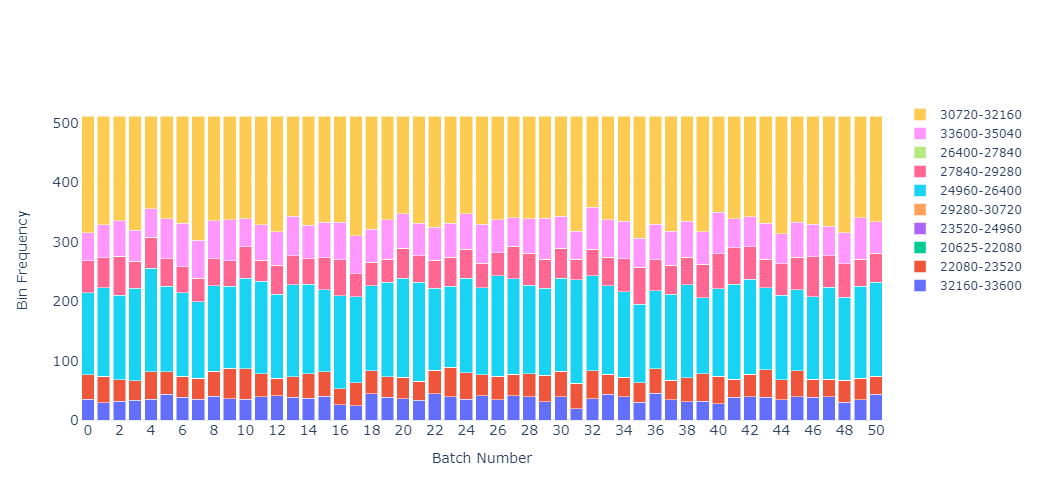

In [239]:
fig = plot_batches(all_batches)
fig.update_layout(
        autosize=False,
        width=900,
        height=500,
    # title_text="",
        yaxis=dict(
            title_text="Bin Frequency",
            titlefont=dict(size=14),
            tickfont=dict(size=14),
        ),
        xaxis=dict(
            title_text="Batch Number",
            titlefont=dict(size=14),
            tickfont=dict(size=14),
        ),
    barmode="stack",
    )
fig.show()

#### With Batch Samplers

We define a probabilitywhich makes the batch balanced across different batches.

We can use the bins of the length of time series and initializing the weights as 1/frequency of each bin. This makes the sampling focus more on low frequency bins and make single batch equal

In [240]:
df = training.index.copy()
df['bins'] = pd.cut(df["count"], bins=10).cat.rename_categories({
    f"bin_{i}" for i, _ in enumerate(range(10)) 
})

weights = 1/df['bins'].value_counts(normalize=True)

weights = weights.reset_index().rename(columns={"index":"bins", "bins":"weight"})
# df = training.index.copy()
df = df.merge(weights, on='bins', how='left')
probabilities = df.weight.values

In [241]:
from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(probabilities, len(probabilities))

In [242]:
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, sampler=sampler, shuffle=False)
all_batches = get_batch_count(train_dataloader, n=50)

  0%|          | 0/50 [00:00<?, ?it/s]

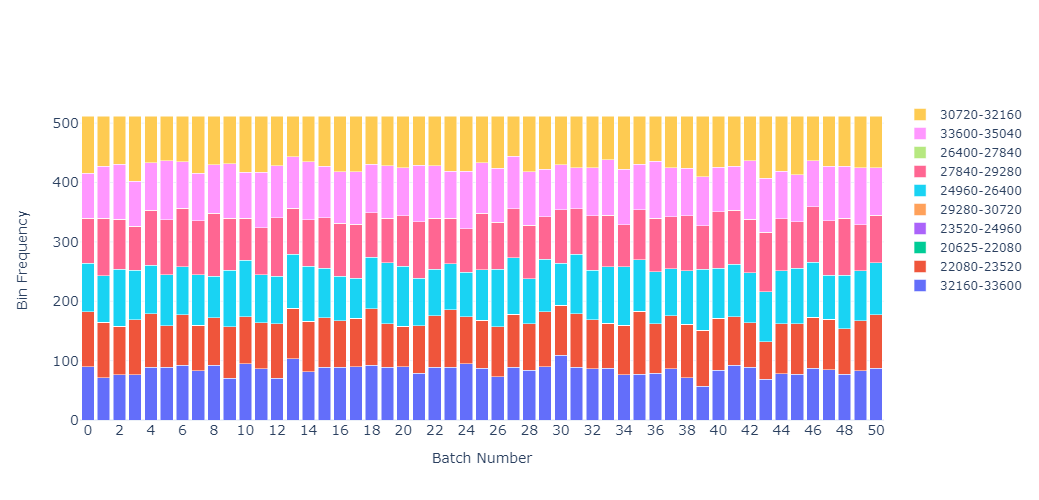

In [243]:
fig = plot_batches(all_batches)
fig.update_layout(
        autosize=False,
        width=900,
        height=500,
    # title_text="",
        yaxis=dict(
            title_text="Bin Frequency",
            titlefont=dict(size=14),
            tickfont=dict(size=14),
        ),
        xaxis=dict(
            title_text="Batch Number",
            titlefont=dict(size=14),
            tickfont=dict(size=14),
        ),
    barmode="stack",
    )
fig.show()

#### Training with the custom sampler

In [167]:
# Making the dataloaders
# num_workers can be increased in linux to speed-up training
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, sampler=sampler, shuffle=False)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [168]:
# Testing the dataloader
x, y = next(iter(train_dataloader))
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")
print("\nsize of y =")
print(f"\ty = {y[0].size()}")


sizes of x =
	encoder_cat = torch.Size([512, 96, 7])
	encoder_cont = torch.Size([512, 96, 2])
	encoder_target = torch.Size([512, 96])
	encoder_lengths = torch.Size([512])
	decoder_cat = torch.Size([512, 1, 7])
	decoder_cont = torch.Size([512, 1, 2])
	decoder_target = torch.Size([512, 1])
	decoder_lengths = torch.Size([512])
	decoder_time_idx = torch.Size([512, 1])
	groups = torch.Size([512, 1])
	target_scale = torch.Size([512, 2])

size of y =
	y = torch.Size([512, 1])


### Creating the Model

### Defining the Forward function

In [171]:
cardinality = [len(training.categorical_encoders[c].classes_) for c in training.categoricals]
embedding_sizes = [
    (x, min(50, (x + 1) // 2))
    for x in cardinality
]

In [172]:
from typing import Dict

class StaticDynamicFeatureRNNModel(SingleStepRNN):
    def __init__(
        self,
        rnn_type: str,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        bidirectional: bool,
        embedding_sizes = []
    ):
        super().__init__(rnn_type, input_size, hidden_size, num_layers, bidirectional)
        self.embeddings = torch.nn.ModuleList(
            [torch.nn.Embedding(card, size) for card, size in embedding_sizes]
        )

    def forward(self, x: Dict):
        # Using the encoder and decoder sequence (explanation in the book)
        x_cont = torch.cat([x["encoder_cont"],x["decoder_cont"]], dim=1)
        # Roll target by 1 (explanation in the book)
        x_cont[:,:,-1] = torch.roll(x_cont[:,:,-1], 1, dims=1)
        # Combine the encoder and decoder categoricals (explanation in the book)
        static_cat = torch.cat([x["encoder_cat"],x["decoder_cat"]], dim=1)
        if static_cat.size(-1)>0:
            x_cat = torch.cat([emb(static_cat[:,:,i]) for i, emb in enumerate(self.embeddings)], dim=-1)
            x = torch.cat([x_cont, x_cat], dim=-1)
        else:
            x = x_cont
        # dropping first timestep (explanation in the book)
        x = x[:,1:,:] # x --> (batch_size, seq_len, input_size)
        # Processing through the RNN
        x, _ = self.rnn(x)  # --> (batch_size, seq_len, hidden_size)
        # Using a FC layer on last hidden state
        x = self.fc(x[:,-1,:])  # --> (batch_size, seq_len, 1)
        return x

In [173]:
model_params = dict(
    rnn_type="LSTM",
    input_size=len(training.reals)+sum([s for _, s in embedding_sizes]),
    hidden_size=256, #128
    num_layers=2,
    bidirectional=False,
    embedding_sizes=embedding_sizes,
)

other_params = dict(
    learning_rate=5e-5,
    optimizer="adam",
    loss=RMSE(),
    logging_metrics=[RMSE(), MAE()],
)

In [174]:
model = SingleStepRNNModel.from_dataset(
    training,
    network_callable=StaticDynamicFeatureRNNModel,
    model_params = model_params,
    **other_params
)
#Testing out the model
x, y = next(iter(train_dataloader))
_ = model(x)
type(_), _.prediction.shape

(pytorch_forecasting.utils.TupleOutputMixIn.to_network_output.<locals>.Output,
 torch.Size([512, 1]))

### Training the model

In [ ]:
saved_model_sampled ='notebooks/Chapter14/saved_models/baseline_time_varying_static_scale_weighted_sampler_sampled.ckpt'
saved_model_full ='notebooks/Chapter14/saved_models/baseline_time_varying_static_scale_weighted_sampler.ckpt'

In [ ]:
if train_model:
    trainer = pl.Trainer(
        auto_select_gpus=True,
        gpus=-1,
        min_epochs=1,
        max_epochs=20,
        callbacks=[
            pl.callbacks.EarlyStopping(monitor="val_loss", patience=2),
            pl.callbacks.ModelCheckpoint(
                monitor="val_loss", save_last=True, mode="min", auto_insert_metric_name=True
            ),
        ],
        # fast_dev_run=True
        # precision = 16
    )
    trainer.fit(
        model,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    #Loading the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
else:
    best_model_path = saved_model_sampled if TRAIN_SUBSAMPLE else saved_model_full
print(f"Loading the model from: {best_model_path}")
best_model = SingleStepRNNModel.load_from_checkpoint(best_model_path)

In [181]:
pred, index = best_model.predict(test, return_index=True, show_progress_bar=True)
index[tag] = pred
pred_df = pred_df.reset_index().merge(index, on=["time_idx","LCLid"], how='left').set_index(feat_config.index_cols)

agg_metrics, eval_metrics_df = evaluate_forecast(
    pred_df = pred_df,
    train_data = full_df,
    fc_column=tag,
    name=tag,
)
metric_record.append(agg_metrics)
individual_metrics[tag]=eval_metrics_df

In [182]:
pd.DataFrame(metric_record)

,Algorithm,MAE,MSE,meanMASE,Forecast Bias
0,simple,0.079929,0.025419,0.942638,-2.840411
1,simple+time_varying,0.079606,0.024328,0.941491,-1.858576
2,simple+static+time_varying,0.076008,0.022752,0.903804,-5.487272
3,simple+static+time_varying+scale,0.077468,0.024239,0.919911,-5.451568
4,simple+static+time_varying+scale+lags,0.077905,0.023125,0.918712,-3.425498
5,simple+static+time_varying+num_sampler,0.078469,0.023964,0.926512,-7.389312
6,simple+static+time_varying+num_sampler_2,0.078534,0.023446,0.931044,-2.901490
